# I) Summary

# Implementation

**DISCLAIMER**: 

- I didn't add **momentum** to BatchNormalization.

In [9]:
from utils import *
import tensorflow as tf
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import Input, Dense, Conv2D, DepthwiseConv2D, BatchNormalization, Dropout, GlobalAveragePooling2D, Reshape, multiply, add, Activation

In [10]:
CONV_KERNEL_INITIALIZER = {
    'class_name': 'VarianceScaling',
    'config': {
        'scale': 2.0,
        'mode': 'fan_out',
        # EfficientNet actually uses an untruncated normal distribution for
        # initializing conv layers, but keras.initializers.VarianceScaling use
        # a truncated distribution.
        # We decided against a custom initializer for better serializability.
        'distribution': 'normal'
    }
}

DENSE_KERNEL_INITIALIZER = {
    'class_name': 'VarianceScaling',
    'config': {
        'scale': 1. / 3.,
        'mode': 'fan_out',
        'distribution': 'uniform'
    }
}

In [11]:
def SqueezeExcitation(x, filters_in, filters_expand, se_ratio):
    """
        Squeeze and Excitation phase.
        
        Parameters:
        -x: Tensor, input tensor of conv layer.
        -filters_in: Integer, dimension of the input space.
        -filters_expand: Integer, Dimension of the output space after expansion
        -se_ratio: Float, ratio use to squeeze the input filters.
    """
    filters_se = max(1, int(filters_in * se_ratio))
    
    # Squeeze.
    se = GlobalAveragePooling2D()(x)
    se = Reshape((1, 1, filters_expand))(se)
    
    # Excitation.
    se = Conv2D(filters=filters_se,
                kernel_size=1,
                padding='same',
                kernel_initializer= CONV_KERNEL_INITIALIZER,
                use_bias=True)(se)
    
    se = Activation(tf.nn.swish)(se)
    
    se = Conv2D(filters=filters_expand,
                kernel_size=1,
                padding='same',
                activation='sigmoid',
                kernel_initializer= CONV_KERNEL_INITIALIZER,
                use_bias=True)(se)
    
    # Scale.
    x = multiply([x, se])
    
    return x

In [12]:
def __bottleneck(inputs, filters_in, filters_out, kernel_size, expansion_coef, se_ratio, stride, dropout_rate):
    """
        Basic bottleneck structure.
        
        Parameters:
        -inputs: Tensor, input tensor of conv layer.
        -filters_in: Integer, dimension of the input space.
        -filters_out: Integer, dimension of the output space.
        -kernel_size: Integer or tuple of 2 integers, width and height of filters.
        -expansion_coef: Integer, expansion coefficient.
        -se_ratio: Float, ratio use to squeeze the input filters.
        -stride: Integer or tuple of 2 integers, conv stride.
    """
    # Dimension of the output space after expansion.
    filters_expand = filters_in * expansion_coef
    
    # Expansion phase.
    if expansion_coef != 1:
        x = Conv2D(filters=filters_expand,
                   kernel_size=1,
                   strides=1,
                   padding='same',
                   kernel_initializer=CONV_KERNEL_INITIALIZER,
                   use_bias=False)(inputs)
        x = BatchNormalization()(x)
        x = Activation(tf.nn.swish)(x)
    else:
        x = inputs
    
    # Dephtwise conv phase.
    x = DepthwiseConv2D(kernel_size=kernel_size,
                        strides=stride,
                        padding='same',
                        depthwise_initializer=CONV_KERNEL_INITIALIZER,
                        use_bias=False)(x)
    x = BatchNormalization()(x)
    x = Activation(tf.nn.swish)(x)
    
    # Squeeze and Excitation phase.
    x = SqueezeExcitation(x, filters_in, filters_expand, se_ratio)
    
    # Output phase.
    x = Conv2D(filters=filters_out,
               kernel_size=1,
               padding='same',
               kernel_initializer=CONV_KERNEL_INITIALIZER,
               use_bias=False)(x)
    
    x = BatchNormalization()(x)
    
    # MobileNetV2 paper: "Add skip connection when stride=1."
    if (stride == 1 and filters_in == filters_out):
        if dropout_rate > 0:
            x = Dropout(dropout_rate)(x)
        x = add([x, inputs])
    
    return x

In [13]:
def MBConvBlock(inputs, filters_in, filters_out, kernel_size, expansion_coef, se_ratio, stride, repeat, dropout_rate):
    """
    """
    x = __bottleneck(inputs, filters_in, filters_out, kernel_size, expansion_coef, se_ratio, stride, dropout_rate)
    
    
    # MobileNetV2 paper: "The first layer of eachsequence has a stride s and all others use stride 1"
    filters_in = filters_out
    stride = 1
    
    for i in range(1, repeat):
        x = __bottleneck(x, filters_in, filters_out, kernel_size, expansion_coef, se_ratio, stride, dropout_rate)
        
    return x

In [14]:
def ConvBlock(inputs, filters, kernel_size, stride=1, padding='same'):
    """
    
    """ 
    x = inputs
    x = Conv2D(filters=filters,
               kernel_size=kernel_size,
               strides=stride,
               padding=padding,
               use_bias=False,
               kernel_initializer=CONV_KERNEL_INITIALIZER)(x)

    x = BatchNormalization()(x)
    x = Activation(tf.nn.swish)(x)
    
    return x

In [15]:
def EfficientNet_B0(channels,
                    expansion_coefs,
                    repeats,
                    strides,
                    kernel_sizes,
                    d_coef,
                    w_coef,
                    r_coef,
                    dropout_rate,
                    se_ratio = 0.25,
                    classes=1000):
    """
    
    """
    inputs = Input(shape=(r_coef, r_coef, 3))
    
    stage1 = ConvBlock(inputs,
                       filters=32,
                       kernel_size=3,
                       stride=2)
    
    stage2 = MBConvBlock(stage1, 
                         scaled_channels(channels[0], w_coef),
                         scaled_channels(channels[1], w_coef),
                         kernel_sizes[0],
                         expansion_coefs[0],
                         se_ratio,
                         strides[0],
                         scaled_repeats(repeats[0], d_coef),
                         dropout_rate=dropout_rate)
    
    stage3 = MBConvBlock(stage2, 
                         scaled_channels(channels[1], w_coef),
                         scaled_channels(channels[2], w_coef),
                         kernel_sizes[1],
                         expansion_coefs[1],
                         se_ratio,
                         strides[1],
                         scaled_repeats(repeats[1], d_coef),
                         dropout_rate=dropout_rate)
    
    stage4 = MBConvBlock(stage3, 
                         scaled_channels(channels[2], w_coef),
                         scaled_channels(channels[3], w_coef),
                         kernel_sizes[2],
                         expansion_coefs[2],
                         se_ratio,
                         strides[2],
                         scaled_repeats(repeats[2], d_coef),
                         dropout_rate=dropout_rate)
    
    stage5 = MBConvBlock(stage4, 
                         scaled_channels(channels[3], w_coef),
                         scaled_channels(channels[4], w_coef),
                         kernel_sizes[3],
                         expansion_coefs[3],
                         se_ratio,
                         strides[3],
                         scaled_repeats(repeats[3], d_coef),
                         dropout_rate=dropout_rate)

    stage6 = MBConvBlock(stage5, 
                         scaled_channels(channels[4], w_coef),
                         scaled_channels(channels[5], w_coef),
                         kernel_sizes[4],
                         expansion_coefs[4],
                         se_ratio,
                         strides[4],
                         scaled_repeats(repeats[4], d_coef),
                         dropout_rate=dropout_rate)
    
    stage7 = MBConvBlock(stage6, 
                         scaled_channels(channels[5], w_coef),
                         scaled_channels(channels[6], w_coef),
                         kernel_sizes[5],
                         expansion_coefs[5],
                         se_ratio,
                         strides[5],
                         scaled_repeats(repeats[5], d_coef),
                         dropout_rate=dropout_rate)
    
    stage8 = MBConvBlock(stage7, 
                         scaled_channels(channels[6], w_coef),
                         scaled_channels(channels[7], w_coef),
                         kernel_sizes[6],
                         expansion_coefs[6],
                         se_ratio,
                         strides[6],
                         scaled_repeats(repeats[6], d_coef),
                         dropout_rate=dropout_rate)
       
    stage9 = ConvBlock(stage8,
                       filters=scaled_channels(channels[8], w_coef),
                       kernel_size=1,
                       padding='same')
    
    stage9 = GlobalAveragePooling2D()(stage9)
    
    if dropout_rate > 0:
        stage9 = Dropout(dropout_rate)(stage9)
    
    stage9 = Dense(classes, 
                   activation='softmax',
                   kernel_initializer=DENSE_KERNEL_INITIALIZER)(stage9)

    model = Model(inputs, stage9)

    return model

In [17]:
channels = [32, 16, 24, 40, 80, 112, 192, 320, 1280]
expansion_coefs = [1, 6, 6, 6, 6, 6, 6]
repeats = [1, 2, 2, 3, 3, 4, 1]
strides = [1, 2, 2, 2, 1, 2, 1]
kernel_sizes = [3, 3, 5, 3, 5, 5, 3]
d_coef, w_coef, r_coef, dropout_rate = efficientnet_params('efficientnet-b0')   

model = EfficientNet_B0(channels,
                        expansion_coefs,
                        repeats,
                        strides,
                        kernel_sizes,
                        d_coef,
                        w_coef,
                        r_coef,
                        dropout_rate)
model.summary()
model.load_weights('data/pretrained_model_imagenet.h5')

Model: "model_2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
conv2d_130 (Conv2D)             (None, 112, 112, 32) 864         input_3[0][0]                    
__________________________________________________________________________________________________
batch_normalization_98 (BatchNo (None, 112, 112, 32) 128         conv2d_130[0][0]                 
__________________________________________________________________________________________________
activation_98 (Activation)      (None, 112, 112, 32) 0           batch_normalization_98[0][0]     
____________________________________________________________________________________________

Using TensorFlow backend.


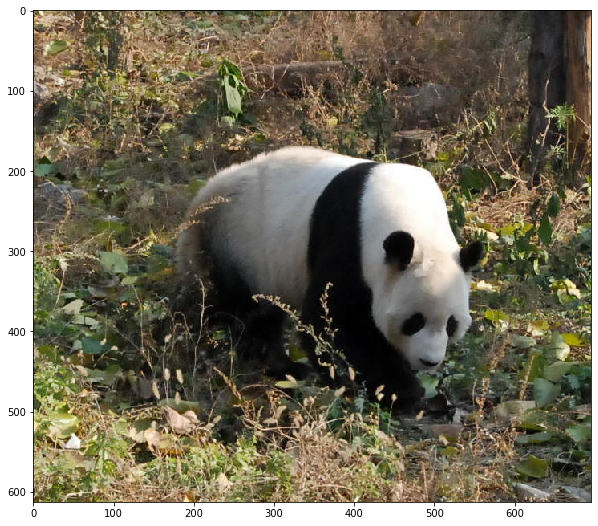

In [18]:
import os
import sys
import numpy as np
from skimage.io import imread
import matplotlib.pyplot as plt
from skimage.transform import resize
from keras.applications.imagenet_utils import decode_predictions

# test image
image = imread('img/panda.jpg')

plt.figure(figsize=(10, 10))
plt.imshow(image)
plt.show()

In [19]:
from keras.applications.imagenet_utils import decode_predictions, preprocess_input

# ImageNet mean and std.
mean=[0.485, 0.456, 0.406]
std=[0.229, 0.224, 0.225]

# preprocess input
image_size = model.input_shape[1]
x = center_crop_and_resize(image, image_size=image_size)
x /= 255
x = (x - mean) / std
x = np.expand_dims(x, 0)

In [20]:
y = model.predict(x)
decode_predictions(y)

[[('n02510455', 'giant_panda', 0.7587868),
  ('n02134084', 'ice_bear', 0.008354766),
  ('n02132136', 'brown_bear', 0.0072072325),
  ('n02509815', 'lesser_panda', 0.0041302308),
  ('n02120079', 'Arctic_fox', 0.004021083)]]